## Import and setup environment

### Download Datasets and Install Libraries

In [ ]:
!pip install autogluon

In [ ]:
!wget 'https://sagemaker-studio-217844980677-v5nqrs89xl.s3.amazonaws.com/data.zip'
!wget 'https://sagemaker-studio-217844980677-v5nqrs89xl.s3.amazonaws.com/DIAS+Attributes+-+Values+2017.xlsx'

In [ ]:
!unzip 'data.zip'

### Setup Environment and Load Data

In [ ]:
# import libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline


from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from autogluon.utils.tabular.ml.utils import generate_train_test_split
from autogluon.tabular import TabularPredictor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb



pd.set_option("display.max_rows", 300)
random_state = 42

In [ ]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
train_mailout = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test_mailout = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

attributes = pd.read_excel('DIAS+Attributes+-+Values+2017.xlsx', header=1)

In [ ]:
azdias.set_index('LNR', inplace=True)
customers.set_index('LNR', inplace=True)
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## EDA

In [ ]:
warning_cols = list(azdias.columns[18:20])
azdias[warning_cols[0]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [ ]:
azdias_object_cols = azdias.columns[azdias.dtypes == "object"]
customer_object_cols = customers.columns[customers.dtypes == "object"]
print("Azdias columns with dtype Object \n",azdias_object_cols.values)
print("Azdias columns with dtype Object \n",customer_object_cols.values)

In [ ]:
def get_missing_report(df):
    """
    Takes in a dataframe and returns a dataframe with information about column-wise missing values percentages.
    """
    missing_percen = df.isna().sum() * 100/ len(df)
    
    missing_percen_df = pd.DataFrame({"Attribute": df.columns,
                                     "Missing_Percentage": missing_percen}).reset_index(drop=True)
    return missing_percen_df

In [ ]:
missing_azdias= get_missing_report(azdias)
missing_customers= get_missing_report(customers)

In [ ]:
remove_cols= (missing_azdias[missing_azdias['Missing_Percentage'] > 30 ]['Attribute']).tolist()
remove_cols

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [ ]:
remove_cols.extend(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'])
remove_cols

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ',
 'CAMEO_DEU_2015',
 'D19_LETZTER_KAUF_BRANCHE']

## Wrangling Data
*Functions*
- clean_unknown_values:
- fix_cameo_cols:
- get_missing_report: Helping function
- drop_cols
- fix_LP_cols:
- fix_datetime_cols:
- fix_ost_west_col:
- fix_cameo_intl_col:

### Helper Functions

In [ ]:
#Finding out what values are unknown so we can replace them later with nan values
unknowns = attributes[attributes['Meaning'] == 'unknown']
unknowns["Value"] = unknowns["Value"].str.split(',').apply(pd.to_numeric)
unknowns.dtypes

<ipython-input-8-6e99483252a7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknowns["Value"] = unknowns["Value"].str.split(',').apply(pd.to_numeric)


Unnamed: 0     float64
Attribute       object
Description     object
Value           object
Meaning         object
dtype: object

In [ ]:
def clean_unknown_values(df):
    
    for attr in unknowns.Attribute:
        value = (unknowns[unknowns["Attribute"] == attr]["Value"]).tolist()
        if attr in df.columns:
            df[attr] = df[attr].replace(value , np.nan)
    return df

In [ ]:
def fix_cameo_cols(df):
    """
    This function is used to clean the alerts in the input dataframe's columns 18,19
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015"]
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    df[cols] = df[cols].astype(float)
    
    return df

In [ ]:
def drop_cols(df, remove_cols=remove_cols):
  df.drop(remove_cols, axis= 1, inplace=True)
  return df

In [ ]:
def fix_LP_cols(df):
    """
    Function to replace 0s with nan values columns,
    ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    """
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
           "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    
    
    # LP_FAMILIE_GROB
    convert_1 = {1: 'single', 2: 'couple', 3: 'singleparent', 4: 'singleparent', 5: 'singleparent', 
                  6: 'family', 7: 'family', 8: 'family', 9: 'multihousehold', 10: 'multihousehold', 11: 'multihousehold'}
    convert_2 = {'single':0, 'couple':1, 'singleparent':2, 'family':3, 'multihousehold':4}
    
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_1)
    df["LP_FAMILIE_GROB"] = df["LP_FAMILIE_GROB"].map(convert_2)
    
    # LP_STATUS_GROB    
    convert_1 = {1: 'lowincome', 2: 'lowincome', 3: 'avgincome', 4: 'avgincome', 5: 'avgincome', 
                  6: 'independant', 7: 'independant', 8: 'houseowner', 9: 'houseowner', 10: 'topearner'}
    convert_2 = {'lowincome':0, 'avgincome':1, 'independant':2, 'houseowner':3, 'topearner':4}
    
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_1)
    df["LP_STATUS_GROB"] = df["LP_STATUS_GROB"].map(convert_2)
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["Temp"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["Temp"].map(wealth_scale)
    
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_FEIN"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_GROB"] = df["LP_LEBENSPHASE_GROB"].map(wealth_scale)
        

    return df

In [ ]:
dates= ['EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'GEBURTSJAHR']

def fix_datetime_cols(df):
    for i in dates:
        df[i] = pd.to_datetime(df[i])
        df[i] = df[i].map(lambda x: x.year)
    
    return df

In [ ]:
def fix_ost_west_col(df):
    """
    Function to label encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    return df

In [ ]:
def fix_cameo_intl_col(df):
    
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else np.nan)
    df['CAMEO_INTL_2015_FAMILY'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else np.nan)
    
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    return df

### Main cleaning function

In [ ]:
def clean_data(cleaned_azdias, df, attributes):

    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_cameo_cols(df)
        
    
    
    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)
    
    print("\tFixing EINGEFUGT column")
    df = fix_datetime_cols(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    df = clean_unknown_values(df)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)

    df = fix_cameo_intl_col(df)
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    
    #cols_to_drop = [col for col in df.columns if col not in azdias.columns]
    df = drop_cols(df)

    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="mean")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    return df

In [ ]:
azidas = clean_data(azidas, attributes)
customers = clean_data(customers, attributes)

In [ ]:
customers_group = customers[['CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE']]
customers.drop(['CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE'], axis=1, inplace=True)

### Testing the functions output

In [ ]:
print(azdias.LP_FAMILIE_FEIN.unique())

print(azdias.LP_FAMILIE_GROB.unique())

print(azdias.LP_STATUS_GROB.unique())

print(azdias.LP_LEBENSPHASE_GROB.unique())

print(azdias.LP_LEBENSPHASE_FEIN.unique())

print(azdias.LP_STATUS_FEIN.unique())

[ 2.  5.  1. nan 10.  7. 11.  3.  8.  4.  6.  9.]
[ 1.  2.  0. nan]
[ 0.  1. nan]
[ 1.  2. nan  3.  4.]
[ 3.  2.  1. nan  4.]
[ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7. nan]


In [ ]:
azdias['CAMEO_INTL_2015_FAMILY'].unique() , azdias['CAMEO_INTL_2015_WEALTH'].unique()

(array([nan,  1.,  4.,  2.,  3.,  5.]), array([nan,  5.,  2.,  1.,  4.,  3.]))

## Scaling and Imputing Values for PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [ ]:
for i in azdias.columns:
    print('{i} : Unique values \n  {unique}'.format(i= i, unique= azdias[i].unique()))

AGER_TYP : Unique values 
  [-0.53520678  1.9674561   2.80167706  0.29901418  1.13323514]
AKT_DAT_KL : Unique values 
  [ 2.48513826e-17  1.25812578e+00 -9.40399443e-01  1.58863170e-01
  9.83310129e-01  7.08494476e-01  4.33678823e-01 -1.15952483e-01
 -3.90768137e-01 -6.65583790e-01]
ALTER_HH : Unique values 
  [ 5.03283943e-17 -1.42206587e+00  8.03158630e-01  2.79576395e-01
  1.19584531e+00 -1.13110281e-01  4.10471954e-01  6.72263071e-01
  1.32674086e+00  1.77852777e-02  1.06494975e+00  5.41367512e-01
 -2.44005840e-01  9.34054188e-01 -3.74901398e-01 -5.05796957e-01
  1.48680836e-01 -8.98483633e-01 -1.02937919e+00 -6.36692516e-01
 -7.67588074e-01 -1.16027475e+00 -1.29117031e+00]
ALTERSKATEGORIE_FEIN : Unique values 
  [ 1.75070137e-17  1.43691056e+00  6.49485012e-01 -1.37940531e-01
  5.89158551e-02 -7.28509688e-01  4.52628627e-01  1.24005417e+00
 -5.31653302e-01  1.04319778e+00  2.55772241e-01  8.46341398e-01
 -9.25366074e-01  1.63376694e+00 -3.34796916e-01 -2.69707355e+00
 -1.12222246e

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

## PCA

In [ ]:
from sklearn.decomposition import PCA
def perform_pca(data, n_components=None):
    pca = PCA(n_components, random_state=random_state)
    pca.fit(data)
    data_transformed = pca.transform(data)
    return pca, data_transformed

In [ ]:
def plot_pca_exp_variance(pca_azdias, cumulative=True, figsize=(8,10)):
    """
    Takes in two PCA models (which are fit on corresponding data) and plots 
    their Explained Variance vs Number of components
    
    """   
    
    if cumulative:
        azdias_variance = np.cumsum(pca_azdias.explained_variance_ratio_)
        y_label = "Percentage Explained Variance"
    else:
        azdias_variance = pca_azdias.explained_variance_ratio_
        y_label = "Explained Variance Ratio"
        
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(211)
    ax.plot(azdias_variance)
    ax.set_xlabel("No. of components")
    ax.set_ylabel(y_label)
    ax.set_title("Azdias - PCA Explained Variance Ratio vs Number of Components")
    ax.grid()
    plt.show()

In [ ]:
pca_azdias, _ = perform_pca(azdias, None)

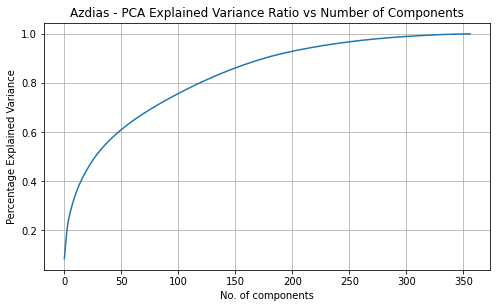

In [ ]:
plot_pca_exp_variance(pca_azdias)

In [ ]:
pca_170, azdias_pca_170 = perform_pca(azdias, n_components=170)

In [ ]:
customers_pca_170 = pca_170.transform(customers)

### PCA Components

In [ ]:
def plot_feature_weights(df, pca, attributes, dimension, n_weights = 5, plot=True,figsize=(7,8)):
    """
    This function displays interesting features of the selected dimension
    """
    
    features = df.columns.values
    components = pca.components_
    feature_weights = dict(zip(features, components[dimension]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    feat_names = []
    feat_weights = []
    feat_descs = []

    for feature, weight in sorted_weights[-n_weights:]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature, weight, in sorted_weights[:n_weights]:
        feat_names.append(feature)
        feat_weights.append(weight)
        
    for feature in feat_names:
        if feature in attributes.Attribute.values:
            feat_descs.append(attributes[attributes.Attribute == feature].Description.values[0])
        else:
            feat_descs.append("No description given")
    
    component_info = {"Feature":feat_names, "Description":feat_descs, "FeatureWeight":feat_weights}
    component_info = pd.DataFrame(component_info)
    component_info.sort_values("FeatureWeight", inplace=True, ascending=False, ignore_index=True)
           
    if plot:
        fig = plt.figure(figsize=figsize)

        ax = fig.add_subplot(211)
        ax.bar(feat_names, feat_weights)
        ax.set_ylabel("Feature Weight")
        ax.set_xlabel("Feature Name")
        ax.set_title("PCA Feature weights - Component {}".format(dimension))
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
        ax.grid()

        fig.tight_layout()
        plt.show()
    
    return component_info

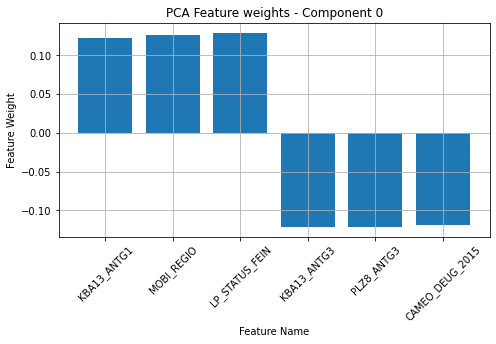

,Feature,Description,FeatureWeight
0,LP_STATUS_FEIN,social status fine,0.129169
1,MOBI_REGIO,moving patterns,0.126022
2,KBA13_ANTG1,No description given,0.121915
3,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-0.118559
4,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.120843
5,KBA13_ANTG3,No description given,-0.121457


In [ ]:
component_0_info = plot_feature_weights(azdias, pca_azdias, attributes, 0, 3)
component_0_info.head(10)

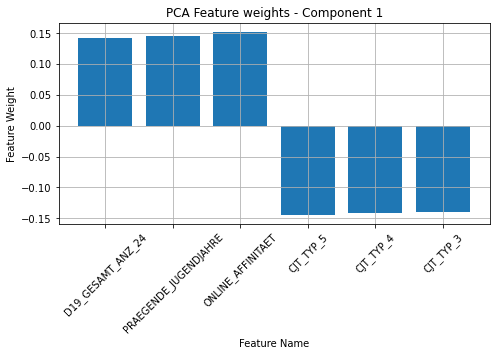

,Feature,Description,FeatureWeight
0,ONLINE_AFFINITAET,online affinity,0.151977
1,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.145527
2,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0.142673
3,CJT_TYP_3,No description given,-0.139825
4,CJT_TYP_4,No description given,-0.141980
5,CJT_TYP_5,No description given,-0.144396


In [ ]:
component_1_info = plot_feature_weights(azdias, pca_azdias, attributes, 1, 3)
component_1_info.head(10)

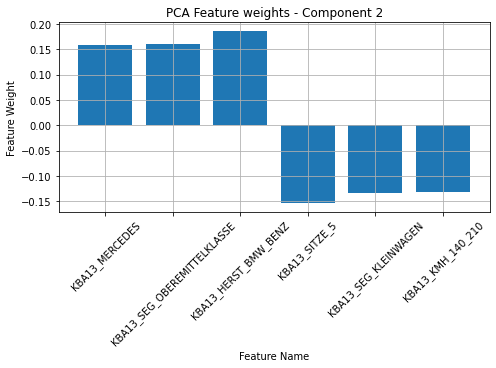

,Feature,Description,FeatureWeight
0,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.185840
1,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.159835
2,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.159311
3,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.132203
4,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.134207
5,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.153791


In [ ]:
component_2_info = plot_feature_weights(azdias, pca_azdias, attributes, 2, 3)
component_2_info.head(10)

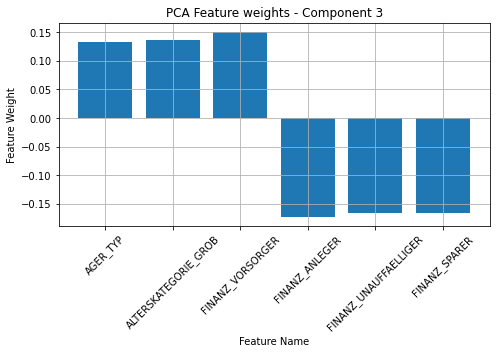

,Feature,Description,FeatureWeight
0,FINANZ_VORSORGER,financial typology: be prepared,0.150926
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,0.137408
2,AGER_TYP,best-ager typology,0.133623
3,FINANZ_SPARER,financial typology: money saver,-0.165862
4,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,-0.166707
5,FINANZ_ANLEGER,financial typology: investor,-0.173462


In [ ]:
component_3_info = plot_feature_weights(azdias, pca_azdias, attributes, 3, 3)
component_3_info.head(10)

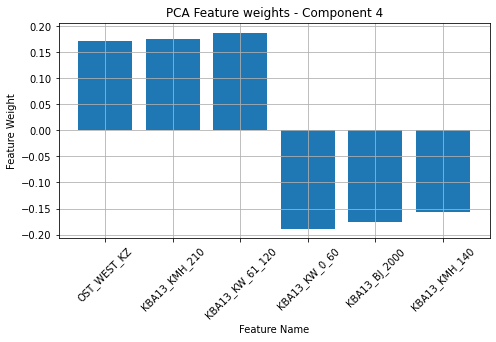

,Feature,Description,FeatureWeight
0,KBA13_KW_61_120,share of cars with an engine power between 61 ...,0.187838
1,KBA13_KMH_210,No description given,0.175077
2,OST_WEST_KZ,flag indicating the former GDR/FRG,0.172305
3,KBA13_KMH_140,share of cars with max speed between 110 km/h ...,-0.156336
4,KBA13_BJ_2000,share of cars built between 2000 and 2003 with...,-0.176482
5,KBA13_KW_0_60,share of cars up to 60 KW engine power - PLZ8,-0.188721


In [ ]:
component_4_info = plot_feature_weights(azdias, pca_azdias, attributes, 4, 3)
component_4_info.head(10)

## Customer Segmentation

In [ ]:
def get_Kmeans_scores(data, K_start, K_end, step=1):
    
    scores = []
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_start, K_end, step))

    for n in range(K_start, K_end+1, step):
        
        print("\nTraining for n_clusters: ", n)
        
        
        kmeans = KMeans(n, random_state=random_state)
        model = kmeans.fit(data)
        scores.append(abs(model.score(data)))
        
        print("Model Score: ", scores[-1])
        
    return scores, range(K_start, K_end+1, step)

In [ ]:
scores, ranges = get_Kmeans_scores(azdias, 2, 17, step=1)

Performing K-Means clustering
Given range min:2, max:17, step:1

Training for n_clusters:  2
Done! Score:  269690428.812183

Training for n_clusters:  3
Done! Score:  260578379.7725212

Training for n_clusters:  4
Done! Score:  255017377.88931984

Training for n_clusters:  5
Done! Score:  250984834.26846206

Training for n_clusters:  6
Done! Score:  247644095.77524072

Training for n_clusters:  7
Done! Score:  244458768.437528

Training for n_clusters:  8
Done! Score:  241907873.15455973

Training for n_clusters:  9
Done! Score:  239829060.20693615

Training for n_clusters:  10
Done! Score:  238256770.02896532

Training for n_clusters:  11
Done! Score:  236525317.09934378

Training for n_clusters:  12
Done! Score:  235227667.92764398

Training for n_clusters:  13
Done! Score:  233998503.8501838

Training for n_clusters:  14
Done! Score:  232793564.54953524

Training for n_clusters:  15
Done! Score:  231776898.63821808

Training for n_clusters:  16
Done! Score:  231041260.83463514

Trai

In [ ]:
def plot_elbow(scores, ranges):
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(ranges, scores, linestyle= "--",marker = "o", color="blue")
    ax.set_xlabel("No. of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs No. of Clusters")
    
    plt.show()

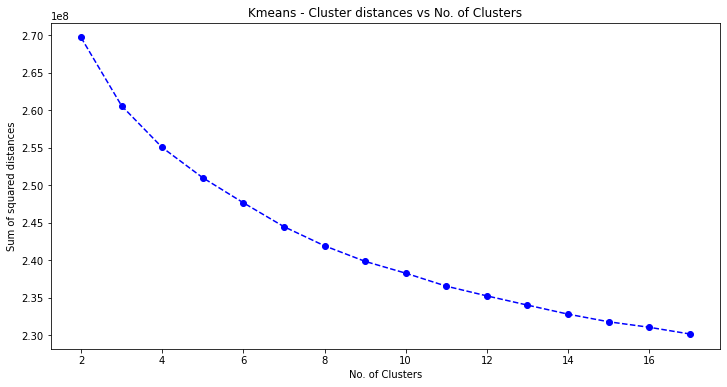

In [ ]:
plot_elbow(scores, ranges)

In [ ]:
kmeans = KMeans(9, random_state=random_state)

kmeans.fit(azdias_pca_170)

KMeans(n_clusters=9, random_state=42)

In [ ]:
azdias_clusters = kmeans.predict(azdias_pca_170)
customers_clusters = kmeans.predict(customers_pca_170)
customers_clusters = pd.Series(customers_clusters)
azdias_clusters = pd.Series(azdias_clusters)

In [ ]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = azdias_clusters.value_counts().sort_index()
cluster_info["Customers"] = customers_clusters.value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)

cluster_info

,Cluster,Population,Customers
0,0,96401,2748
1,1,126856,39205
2,2,87831,46893
3,3,69993,4628
4,4,114115,19086
5,5,131706,40206
6,6,65773,3252
7,7,74039,34018
8,8,124507,1616


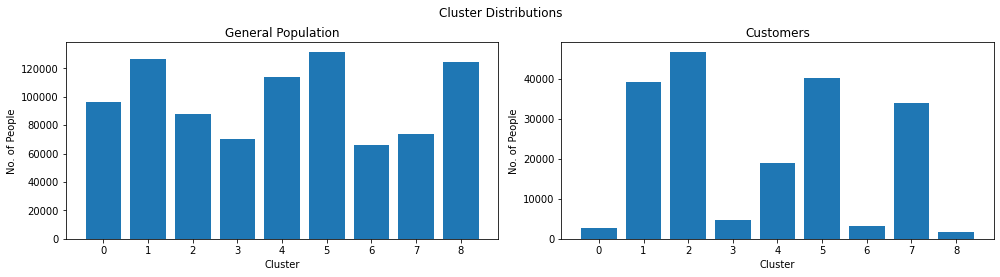

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))

ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
ax1.set_xlabel("Cluster")
ax1.set_ylabel("No. of People")
ax1.set_title("General Population")
ax1.set_xticks(cluster_info["Cluster"])

ax2.bar(cluster_info["Cluster"], cluster_info["Customers"])
ax2.set_xlabel("Cluster")
ax2.set_ylabel("No. of People")
ax2.set_title("Customers")
ax2.set_xticks(cluster_info["Cluster"])

fig.suptitle("Cluster Distributions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.show()

### Explaining Clusters

In [ ]:
def explain_cluster(kmeans_model, cluster_no, data, pca_model, attributes_info, num_components=2, num_feat_per_comp=3):
    
    weights = kmeans_model.cluster_centers_[cluster_no]
    components = list(range(len(weights)))
    
    cluster_expl = pd.DataFrame({"Weights":weights, "Component":components})
    cluster_expl.sort_values("Weights", ascending=False, inplace=True, ignore_index=True)

    comps = []
    weights = []
    comp_infos = []
    for index, row in cluster_expl.head(n=num_components).iterrows():
        
        component_info = plot_feature_weights(data, pca_model, attributes, 
                                                int(row["Component"]), num_feat_per_comp, False)
        comp_infos.append(component_info)
        comps += [int(row["Component"])] * len(component_info)
        weights +=  [row["Weights"]] * len(component_info)
        
    component_info = pd.concat(comp_infos, ignore_index=True)
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(comps))
        
    return component_info

In [ ]:
cluster_1 = explain_cluster(kmeans, 1, azdias, pca_170, attributes)
cluster_1

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,7.983549,LP_STATUS_FEIN,social status fine,0.129169
1,0,7.983549,MOBI_REGIO,moving patterns,0.126022
2,0,7.983549,KBA13_ANTG1,No description given,0.121915
3,0,7.983549,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-0.118559
4,0,7.983549,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.120843
5,0,7.983549,KBA13_ANTG3,No description given,-0.121457
6,1,3.059612,ONLINE_AFFINITAET,online affinity,0.151977
7,1,3.059612,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,0.145527
8,1,3.059612,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0.142673
9,1,3.059612,CJT_TYP_3,No description given,-0.139825


In [ ]:
cluster_2 = explain_cluster(kmeans, 2, azdias, pca_170, attributes)
cluster_2

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,9,3.409547,KOMBIALTER,No description given,0.245940
1,9,3.409547,SEMIO_REL,affinity indicating in what way the person is ...,0.145954
2,9,3.409547,CJT_TYP_3,No description given,0.143101
3,9,3.409547,SHOPPER_TYP,shopping typology,-0.216493
4,9,3.409547,VERS_TYP,insurance typology,-0.236502
5,9,3.409547,HEALTH_TYP,health typology,-0.244748
6,8,3.341706,KOMBIALTER,No description given,0.219636
7,8,3.341706,KBA13_ALTERHALTER_45,share of car owners between 31 and 45 within t...,0.167184
8,8,3.341706,KBA13_HALTER_40,share of car owners between 36 and 40 within t...,0.151070
9,8,3.341706,KBA13_ALTERHALTER_61,share of car owners elder than 61 within the PLZ8,-0.185565


In [ ]:
cluster_5 = explain_cluster(kmeans, 5, azdias, pca_170, attributes)
cluster_5

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,0,3.327004,LP_STATUS_FEIN,social status fine,0.129169
1,0,3.327004,MOBI_REGIO,moving patterns,0.126022
2,0,3.327004,KBA13_ANTG1,No description given,0.121915
3,0,3.327004,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-0.118559
4,0,3.327004,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8,-0.120843
5,0,3.327004,KBA13_ANTG3,No description given,-0.121457
6,6,0.496302,KBA05_MAXSEG,most common car segment in the microcell,0.137256
7,6,0.496302,KBA13_SEG_MITTELKLASSE,share of middle class cars (Ford Mondeo etc.) ...,0.136316
8,6,0.496302,KBA05_MAXVORB,most common preowner structure in the microcell,0.125757
9,6,0.496302,KBA05_KRSKLEIN,share of small cars (referred to the county av...,-0.166694


In [ ]:
cluster_7 = explain_cluster(kmeans, 7, azdias, pca_170, attributes)
cluster_7

,Component,ComponentWeight,Feature,Description,FeatureWeight
0,2,6.159881,KBA13_HERST_BMW_BENZ,share of BMW & Mercedes Benz within the PLZ8,0.185840
1,2,6.159881,KBA13_SEG_OBEREMITTELKLASSE,share of upper middle class cars and upper cla...,0.159835
2,2,6.159881,KBA13_MERCEDES,share of MERCEDES within the PLZ8,0.159311
3,2,6.159881,KBA13_KMH_140_210,share of cars with max speed between 140 and 2...,-0.132203
4,2,6.159881,KBA13_SEG_KLEINWAGEN,share of small and very small cars (Ford Fiest...,-0.134207
5,2,6.159881,KBA13_SITZE_5,number of cars with 5 seats in the PLZ8,-0.153791
6,0,2.227678,LP_STATUS_FEIN,social status fine,0.129169
7,0,2.227678,MOBI_REGIO,moving patterns,0.126022
8,0,2.227678,KBA13_ANTG1,No description given,0.121915
9,0,2.227678,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-0.118559


# Supervised learning model for mailout

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
label = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

0    42430
1      532
Name: RESPONSE, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


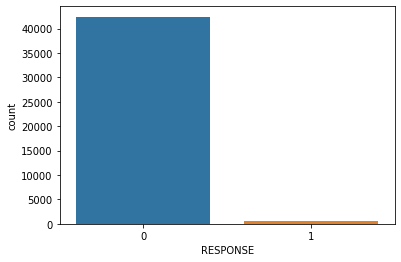

In [ ]:
print(mailout_train.RESPONSE.value_counts())
sns.countplot("RESPONSE", data=mailout_train)

In [ ]:
mailout_train= drop_cols(mailout_train, ['LNR', 'RESPONSE'])

In [ ]:
def clean_data_for_supervised(cleaned_azdias, df, attributes):

    # Fixing columns 18 and 19
    print("\tFixing 18, 19 columns")
    warning_cols = list(df.columns[18:20])
        
    # Ignore if these cols are already cleaned 
    if not (df[warning_cols[0]].dtype == 'float64') & (df[warning_cols[1]].dtype == 'float64'):
        df = fix_cameo_cols(df)
        
    
    
    print("\tFixing LP_* columns")
    df = fix_LP_cols(df)
    
    print("\tFixing EINGEFUGT column")
    df = fix_datetime_cols(df)
    
    # Replacing "Unkown" values with "np.nan"
    print("\tReplacing 'unkown' values with 'NaN'")
    df = clean_unknown_values(df)
    
    # Encoding OST_WEST_KZ col
    print("\tEncoding OST_WEST_KZ column")
    df = fix_ost_west_col(df)

    df = fix_cameo_intl_col(df)
    # Dropping columns which are not in azdias
    print("\tDropping extra columns")
    
    #cols_to_drop = [col for col in df.columns if col not in azdias.columns]
    df = drop_cols(df)

    # Imputing Missing data
    print("\tImputing missing values with most frequent ones")
    imputer = SimpleImputer(strategy="mean")
    
    imputer.fit(azdias)
    df = pd.DataFrame(imputer.transform(df), columns = df.columns)
    
    return df

In [ ]:
mailout_train = clean_data_for_supervised(azdias, mailout_train, attributes)

	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Dropping extra columns
	Imputing missing values with most frequent ones


In [ ]:
mailout_train.shape

(42962, 357)

Baseline Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, label, stratify=label, test_size=0.2, random_state=random_state)

lr = LogisticRegression(random_state=random_state)

lr.fit(X_train, y_train)
pred = lr.predict_proba(X_val)[:,1]

pred

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0.04212901, 0.04170626, 0.01415152, ..., 0.00975492, 0.0048297 ,
       0.00231002])

In [ ]:
print("Baseline AUROC - ", roc_auc_score(y_val, pred))

Baseline AUROC -  0.7200179631000576


Other models

In [ ]:
scaler = StandardScaler()

mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train, label, stratify=label, test_size=0.2, random_state=random_state)

In [ ]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data

    Outputs - AUROC score 
    """
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    return roc_score

In [ ]:
models = [("LogisticRegression", LogisticRegression(random_state=random_state)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=random_state)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=random_state)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=random_state)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=random_state)),
         ("XGBClassifier",xgb.XGBClassifier(random_state=random_state))]

results_reduced = {"Model":[],
          "AUCROC_score":[]}

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results_reduced["Model"].append(name)
    results_reduced["AUCROC_score"].append(roc)
    
    
results_reduced = pd.DataFrame.from_dict(results_reduced, orient='index').transpose()
results_reduced

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.702652,None
1,DecisionTreeClassifier,0.510095,None
2,RandomForestClassifier,0.600276,None
3,GradientBoostingClassifier,0.77013,None
4,AdaBoostClassifier,0.740869,None
5,XGBClassifier,0.686039,None


In [ ]:
param_grid = {"n_estimators": [50,100,150,200],
              "learning_rate": [0.01,0.1,0.5,0.9,1.],
              "algorithm":["SAMME.R"]
              }

adaboost_grid = GridSearchCV(estimator = AdaBoostClassifier(random_state=random_state), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 5, n_jobs = -1, verbose=2)

In [ ]:
adaboost_grid.fit(X_train, y_train)

best_adaboost = adaboost_grid.best_estimator_

print("Best Score: ", adaboost_grid.best_score_)
print("Best Params: ", adaboost_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score:  0.7619448388266867
Best Params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
preds_adaboost = best_adaboost.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds_adaboost)))

ROC score on validation data: 0.7722


In [ ]:
def plot_feature_importances(model, model_name, feature_names, num_features=10):
    """
    Plots top n feature importances for the given model
    """

    
    feature_importance_values= np.zeros((len(model.feature_importances_)))
    
    feature_importance_values += model.feature_importances_

    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # sort based on importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])
    
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.barh(list(reversed(list(feature_importances.index[:num_features]))), 
                feature_importances['normalized_importance'][:num_features], 
                align = 'center')

    # Set ticks and labels
    ax.set_yticks(list(reversed(list(feature_importances.index[:num_features]))))
    ax.set_yticklabels(feature_importances['feature'][:num_features])
    ax.set_xlabel('Normalized Importance')
    ax.set_title(f'Feature Importances ({model_name})') 

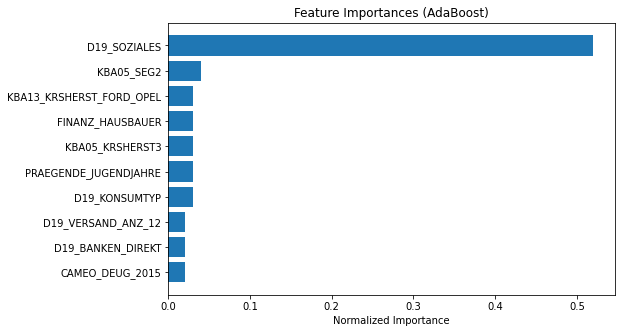

In [ ]:
plot_feature_importances(model=best_adaboost, model_name="AdaBoost", feature_names=mailout_train.columns)

## Autogluon Training

In [ ]:
combined_train = X_train
combined_train['RESPONSE'] = label
predictor = TabularPredictor(label='RESPONSE', eval_metric='roc_auc').fit(combined_train, time_limit=600, presets='best_quality')
predictor.fit_summary()

No path specified. Models will be saved in: "AutogluonModels/ag-20221211_015325/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221211_015325/"
AutoGluon Version:  0.6.0
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Aug 26 08:44:51 UTC 2022
Train Data Rows:    34369
Train Data Columns: 357
Label Column: RESPONSE
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Gen

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.777851       8.189339  163.886536                0.007402          10.279342            2       True         12
1           CatBoost_BAG_L1   0.767140       0.378276   65.714697                0.378276          65.714697            1       True          7
2           LightGBM_BAG_L1   0.762490       0.368800   35.779063                0.368800          35.779063            1       True          4
3         LightGBMXT_BAG_L1   0.758643       0.329957   38.537738                0.329957          38.537738            1       True          3
4            XGBoost_BAG_L1   0.755987       1.660933   25.245924                1.660933          25.245924            1       True         11
5    NeuralNetFastAI_BAG_L1   0.634392       4.021423  106.615764         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.5112599706301327,
  'KNeighborsDist_BAG_L1': 0.5112645350345008,
  'LightGBMXT_BAG_L1': 0.7586426650920854,
  'LightGBM_BAG_L1': 0.7624902159226065,
  'RandomForestGini_BAG_L1': 0.5921622745339847,
  'RandomForestEntr_BAG_L1': 0.5870400446260432,
  'CatBoost_BAG_L1': 0.7671396496

In [ ]:
predictions = predictor.predict_proba(X_val)
predictions.head()

,0,1
4649,0.992941,0.007059
19669,0.955371,0.044629
35146,0.993837,0.006163
38408,0.971524,0.028476
31451,0.992623,0.007377


# Test Data

In [ ]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mailout_test_LNR = mailout_test["LNR"]
mailout_test.drop('LNR', axis=1, inplace=True)
mailout_test = clean_data_for_supervised(azdias, mailout_test, attributes)
mailout_test = pd.DataFrame(scaler.transform(mailout_test), columns = mailout_test.columns)

	Fixing 18, 19 columns
	Fixing LP_* columns
	Fixing EINGEFUGT column
	Replacing 'unkown' values with 'NaN'
	Encoding OST_WEST_KZ column
	Dropping extra columns
	Imputing missing values with most frequent ones


In [ ]:
best_adaboost.fit(mailout_train, label)
preds_test_adaboost = best_adaboost.predict_proba(mailout_test)[:,1]
kaggle_adaboost = pd.DataFrame(index=mailout_test_LNR, data=preds_test_adaboost)
kaggle_adaboost.rename(columns={0: "RESPONSE"}, inplace=True)


kaggle_adaboost.head()

,RESPONSE
LNR,
1754,0.416884
1770,0.416070
1465,0.367281
1470,0.369036
1478,0.368415


In [ ]:
kaggle_adaboost.to_csv("submission1.csv")